# Índice S&P 500

- El S&P 500 es un índice bursátil de referencia que comprende alrededor de 500 de las empresas estadounidenses más grandes clasificadas por capitalización de mercado.


In [23]:
import yfinance as yf
from arch import arch_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Descargar OHLC (Open, High, Low, Close)
# -------------------------

# Descargar OHLC para S&P500 (ticker ^GSPC) desde 2014 al 17-10-2025
df = yf.download("^GSPC", start = "2014-01-01", end = "2025-12-31", auto_adjust = False, progress = False)

# Open - Close
sp = df[['Open','Close']].dropna().copy()
sp.index = pd.to_datetime(sp.index)

# 1) Movimiento intradía: (Close - Open) / Open en %
sp['Mov_%'] = 100 * (sp['Close'] - sp['Open']) / sp['Open']

# 2) Retorno real, en %
sp['%_al_cierre_previo'] = 100 * (sp['Close'] / sp['Close'].shift(1) - 1)

# 3) Estadísticas básicas: desvío estándar de los retornos
std_mov_open2close = sp['Mov_%'].std()          # desvío de movimiento intradía
std_ret_prevclose = sp['%_al_cierre_previo'].std()            # desvío de retornos diarios

sp.columns = sp.columns.droplevel(1)  # elimina el segundo nivel
sp.reset_index(inplace = True)         # elimina el tercer nivel

# Agregamos columnas de proporción y porcentaje diario
sp['%_al_cierre_previo'] = (sp['Close'] - sp['Close'].shift(1)) / sp['Close'].shift(1)
sp['%_al_cierre_previo'] = sp['%_al_cierre_previo'] * 100

sp.head()


Price,Date,Open,Close,Mov_%,%_al_cierre_previo
0,2014-01-02,1845.859985,1831.979980,-0.751953,NaN
1,2014-01-03,1833.209961,1831.369995,-0.100369,-0.033297
2,2014-01-06,1832.310059,1826.770020,-0.302353,-0.251177
3,2014-01-07,1828.709961,1837.880005,0.501449,0.608176
4,2014-01-08,1837.900024,1837.489990,-0.022310,-0.021221


In [24]:
# Mostrar resultados resumidos
print("\n--- Resumen ---")
print(f"Observaciones (días): {len(sp)}")     # Número de días del mercado abierto
print(f"Desvío estándar (mov. intradía Open → Close): {std_mov_open2close:.4f} %")  # Movimiento promedio diario %
print(f"Desvío estándar (retorno Close vs prev Close): {std_ret_prevclose:.4f} %")  # Desvío estándar dario % (no es igual al anterior ya que el precio de apertura puede no ser el mismo que el precio de cierre del día previo)


--- Resumen ---
Observaciones (días): 3017
Desvío estándar (mov. intradía Open → Close): 0.8775 %
Desvío estándar (retorno Close vs prev Close): 1.0996 %


---
# Análisis diario del S&P 500 (2014–2025)

- En este análisis se descargaron los datos históricos del índice **S&P 500** desde el **1 de enero de 2014** hasta el **31 de diciembre de 2025**.

## Datos analizados
- **Variables:** Precio de apertura y cierre de cada día hábil (operativos).  
- **Período:** 2014–2025 
- **Total de observaciones:** 3017 días de mercado abierto.  

## Resultados clave
| Métrica | Descripción | Valor |
|:--------|:-------------|------:|
| Desvío estándar (Open → Close) | Volatilidad intradía: movimiento entre apertura y cierre del mismo día | **∼ 0.88 %** |
| Desvío estándar (Close vs. prev Close) | Volatilidad diaria total (comparando cierres consecutivos) | **∼ 1.10 %** |

<br>

---

## Interpretación
- Un desvío estándar diario del **1.10 %** implica que, en promedio, el precio del S&P 500 fluctúa alrededor de 1.10% respecto al cierre del día anterior.   

<br>

---

---

## 1.1 **Gráfico de variación del precio del S&P 500**

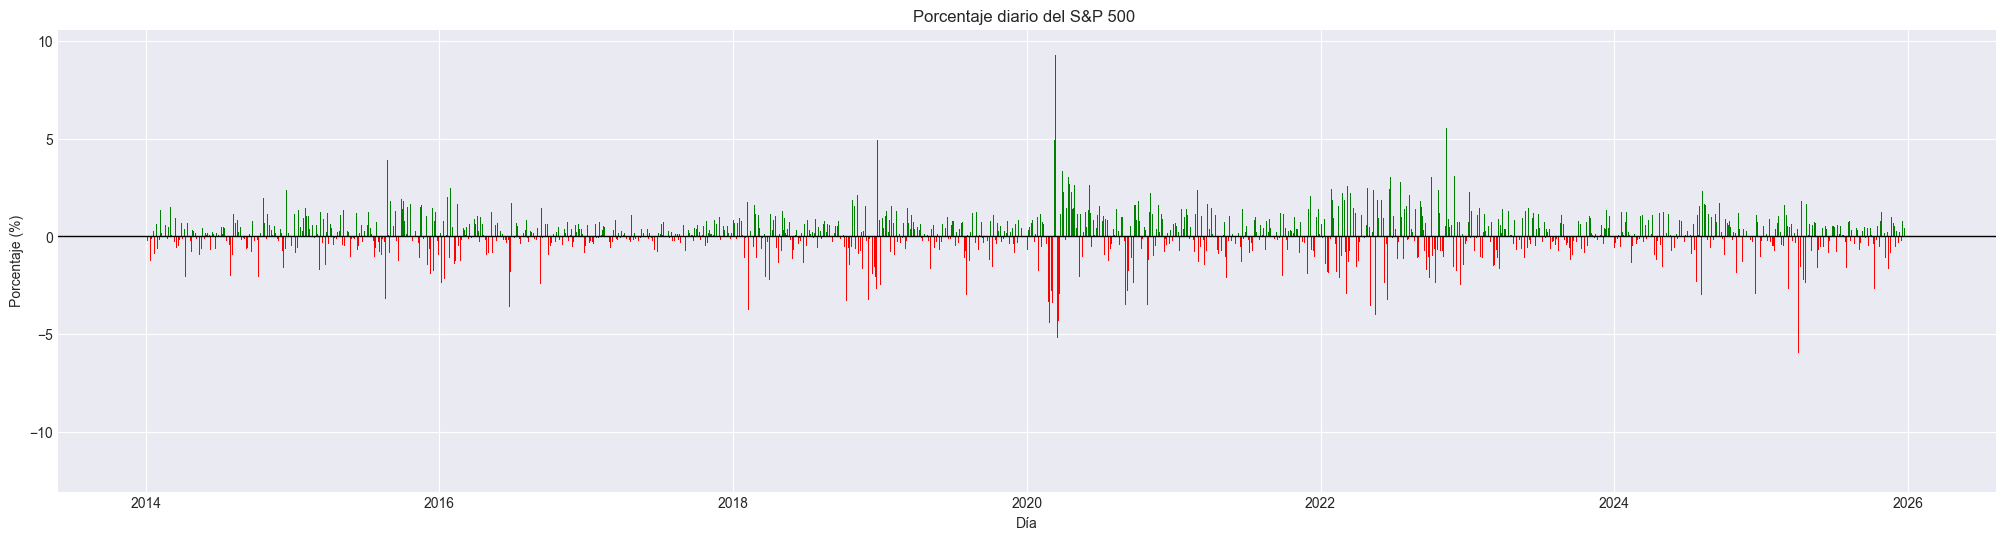

In [25]:
plt.figure(figsize = (25,6))
plt.bar(sp["Date"], sp["%_al_cierre_previo"],
        color = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in sp["%_al_cierre_previo"]], width = 1.0)
plt.title("Porcentaje diario del S&P 500 ")
plt.xlabel("Día")
plt.ylabel("Porcentaje (%)")
plt.axhline(0, color = 'black', linewidth = 1)
plt.show()

Cada barra representa el movimiento del índice en un día de mercado:

- **Verde:** día positivo (suba del índice).  
- **Rojo:** día negativo (baja del índice).  
- La línea negra horizontal en **y = 0** marca la línea de equilibrio.

## Observaciones
- La mayoría de los movimientos diarios se concentran dentro del rango de **∼ ±2 %**, reflejando estabilidad del índice.  
- Se observan **picos excepcionales** de volatilidad, como los ocurridos en **2020** (crisis del COVID-19), con variaciones superiores al **±5 %**.  
- La tendencia general muestra que las subas y bajas se distribuyen de forma **relativamente simétrica**, aunque los descensos suelen ser más abruptos en los períodos de crisis.

## Interpretación
Este gráfico permite visualizar la **dinámica del riesgo diario** del mercado estadounidense:
- El **S&P 500** muestra una volatilidad moderada.   
- A pesar de los eventos extremos, el comportamiento global es **estable y predecible a largo plazo**.

<br>

---

---

## 1.2 **Gráfico de caja para analizar volatilidad diaria**

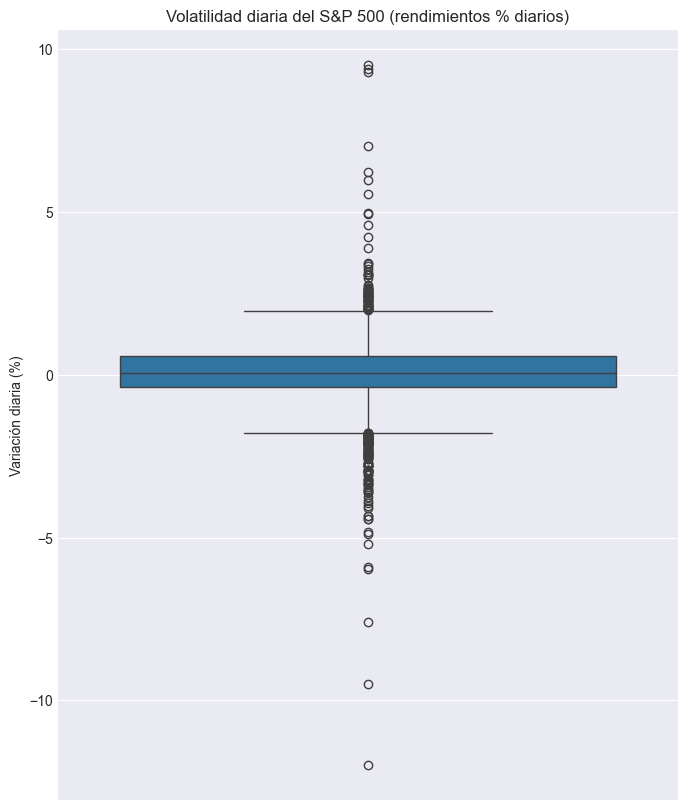

In [26]:
plt.figure(figsize=(8,10))
sns.boxplot(data = sp, y = '%_al_cierre_previo')
plt.title("Volatilidad diaria del S&P 500 (rendimientos % diarios)")
plt.ylabel("Variación diaria (%)")
plt.show()

---

- Podemos ver la mediana ~ 0.00 y la caja no se dispersa demasiado de este valor, sin embargo, se observa presencia de muchos outliers.  
Este gráfico nos habla de posibles tendencias claras **(o lateralización)** en el precio del índice, pero los outliers indican días en que el precio se dispersa mucho de su rango de movimiento habitual. Este hecho puede deberse a noticias o eventos específicos, como por ejemplo, una declaración de guerra en el mundo (sucesos recientes), bajas o subas en el tipo de interés (FED: Estados Unidos), etc.  
Si bien los outliers no suelen superar **± 10 %**, existen muchos días de movimientos más allá de la media del desvío estándar **± 3-4 %**.

---

---

## 1.3 **Modelado Garch(1,1)**

- El análisis GARCH (Heteroscedasticidad Condicional Autorregresiva Generalizada) es un método estadístico para analizar y pronosticar la volatilidad en datos de series temporales, como los rendimientos financieros. Se utiliza para modelar la varianza condicional que cambia en el tiempo, superando la limitación de los modelos tradicionales que asumen una varianza constante. Para esto, utiliza una ecuación de media y una de varianza, donde los parámetros de la varianza (omega(ω) , alpha(α) , beta(β)) describen el nivel base de volatilidad, el impacto de los shocks recientes y la persistencia de la volatilidad pasada. 

In [27]:
# Descargar precios de BTC
data = yf.download("^GSPC", start = "2014-01-01", end = "2025-12-31")['Close']

# Calcular rendimientos diarios (%)
returns = 100 * data.pct_change().dropna()

# Modelo GARCH(1,1)
model = arch_model(returns, vol = 'GARCH', p = 1, q = 1, mean = 'constant', dist = 'normal')
result = model.fit()
print(result.summary())

alpha = result.params['alpha[1]']
beta = result.params['beta[1]']
omega = result.params['omega']

print(f"\nalpha = {alpha:.3f},\n beta = {beta:.3f},\n alpha+beta = {alpha+beta:.3f}")


C:\Users\agust\AppData\Local\Temp\ipykernel_17884\2619615681.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start = "2014-01-01", end = "2025-12-31")['Close']
[*********************100%***********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33590.582157476456
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17482.614506274404
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6156.330775254497
Iteration:      4,   Func. Count:     34,   Neg. LLF: 6674.508763652657
Iteration:      5,   Func. Count:     40,   Neg. LLF: 4309.821680962696
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3825.931013978351
Iteration:      7,   Func. Count:     53,   Neg. LLF: 3825.616740126081
Iteration:      8,   Func. Count:     58,   Neg. LLF: 3825.6125135063453
Iteration:      9,   Func. Count:     63,   Neg. LLF: 3825.6124496833236
Iteration:     10,   Func. Count:     68,   Neg. LLF: 3825.612445186907
Iteration:     11,   Func. Count:     72,   Neg. LLF: 3825.6124451869327
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3825.612445186907
            Iterations: 11
            Function evaluations: 72
            Gradient evaluation

---

## Interpretación clave:

| Parámetro     | Significado                                                                                        | Si es **grande**                                                                                                                                           | Si es **chico**                                                                                             |
| ------------- | -------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| **α (alpha)** | Reacción de la volatilidad ante *nuevas noticias o shocks recientes* (volatilidad de corto plazo)  | La volatilidad reacciona **rápido y fuerte** a los nuevos shocks de mercado. Cada sorpresa grande en el precio genera una subida inmediata de la varianza. | La volatilidad no reacciona mucho al impacto de una nueva noticia; los shocks recientes tienen poco efecto. |
| **β (beta)**  | *Persistencia de la volatilidad* (memoria del sistema). Mide cuánto influye la volatilidad pasada. | La volatilidad es **muy persistente**; si un día es volátil, los días siguientes también lo serán (volatilidad prolongada).                                | La volatilidad se disipa rápido; los shocks se olvidan pronto.                                              |

<br>

---

## Resultados del modelo GARCH(1,1) — S&P 500 (2014–2025)

| Parámetro | Valor |
|:-----------|:------:|
| **α (alpha)** | 0.179 |
| **β (beta)** | 0.789 |
| **α + β** | 0.968 |

## Interpretación general

- El valor **α = 0.179** relativamente alto, sugiere que la volatilidad del S&P 500 responde **muy rápidamente** ante eventos de corto plazo. El índice es sensible a noticias fundamentales.  
- **β = 0.789** muy elevado, indica que esa volatilidad **es persistente**, es decir, si hoy hay volatilidad alta, mañana, **muy probablemente**, también.  
- La suma **α + β ≈ 0.97** confirma que la volatilidad es **altamente persistente**, pero sin ser explosiva (el proceso es estacionario).  

<br>

---

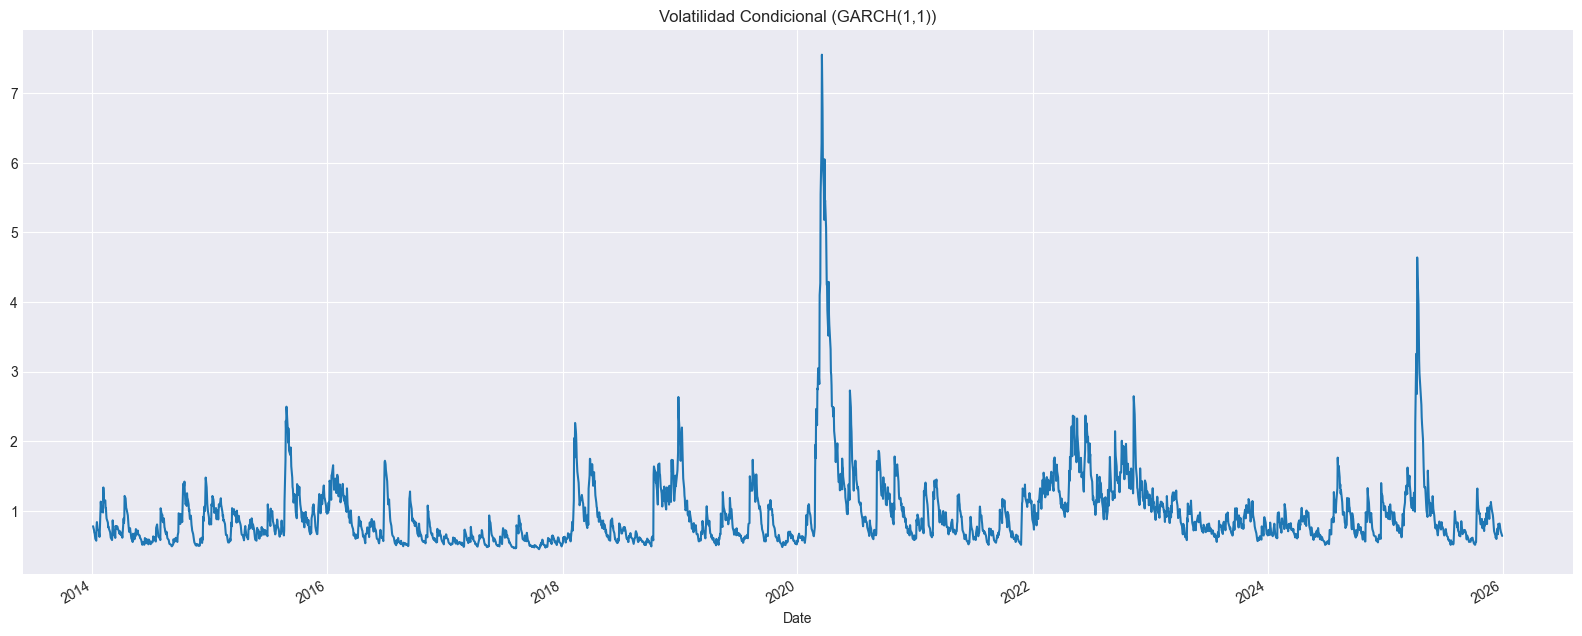

In [28]:
# Predicciones de volatilidad condicional
vol_pred = result.conditional_volatility
vol_pred.plot(title = "Volatilidad Condicional (GARCH(1,1))", figsize = (20,8))
plt.show()

---

## Volatilidad Condicional del S&P 500 — Modelo GARCH(1,1)

## Modelo utilizado
El modelo GARCH(1,1) se basa en la ecuación:

$$
\sigma_t^2 = \omega + \alpha \, \varepsilon_{t-1}^2 + \beta \, \sigma_{t-1}^2
$$

donde:
- $\sigma_t^2$ es la varianza condicional (volatilidad al cuadrado),
- $\varepsilon_{t-1}$ es el residuo del período anterior,
- $\omega, \alpha, \beta$ son parámetros ajustados mediante máxima verosimilitud.

---

## Resultados observados
- Se aprecian **picos aislados** de alta volatilidad asociados a eventos financieros específicos, destacándose:
  - **2020**: crisis del COVID-19.
  - **2022**: tensiones inflacionarias y política monetaria restrictiva.
- Fuera de estos eventos, la volatilidad se mantiene **estable y moderada**, en torno al 0.5–1.5%.

<br>

---

---

## 1.4 **Análisis post-GRACH(1,1)**

In [29]:
# Ajustar modelo GARCH(1,1)
model = arch_model(returns, vol = 'GARCH', p = 1, q = 1, mean = 'constant', dist = 'normal')
result = model.fit(disp = 'off')

print(result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3825.61
Distribution:                  Normal   AIC:                           7659.22
Method:            Maximum Likelihood   BIC:                           7683.27
                                        No. Observations:                 3016
Date:                Wed, Feb 11 2026   Df Residuals:                     3015
Time:                        08:29:46   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0813  1.330e-02      6.112  9.835e-10 [5.522e-0

---

<br>

  > Tras ajustar el modelo **GARCH(1,1)** sobre los rendimientos diarios del **S&P 500**, se obtuvieron los siguientes parámetros estimados:

| Parámetro | Estimador | Error Std. | Valor t | p-valor | Intervalo Conf. (95%) |
|------------|------------|------------|----------|----------|------------------------|
| **μ** (media) | 0.0819 | 0.0134 | 6.10 | 1.07×10⁻⁹ | [0.056, 0.108] |
| **ω** (omega) | 0.0390 | 0.0095 | 4.13 | 3.63×10⁻⁵ | [0.020, 0.058] |
| **α₁** (alpha) | 0.1795 | 0.0259 | 6.92 | 4.42×10⁻¹² | [0.129, 0.230] |
| **β₁** (beta) | 0.7888 | 0.0265 | 29.76 | 1.38×10⁻¹⁹⁴ | [0.737, 0.841] |

## Interpretación estadística
- Todos los coeficientes presentan **p-valores extremadamente bajos (≪ 0.01)** → evidencia **muy fuerte** de que cada parámetro es estadísticamente significativo.  
- Los parámetros **α₁ + β₁ = 0.9683**, lo cual sugiere una **alta persistencia en el movimiento**, ya sea si se presenta un mercado volátil o un período de movimiento más conservador.  
- El valor de **ω (omega)** es chico, lo que indica que los nuevos choques en la volatilidad tienen efecto, pero se disipan lentamente.  
- La media **μ ≈ 0.08% diaria** refleja el retorno esperado del índice.

## Conclusión
El modelo GARCH(1,1) muestra:
- Volatilidad persistente y agrupada temporalmente (clustering).  
- Parámetros altamente significativos.

<br>

---

---

## 1.5 **Value at Risk (VaR)**

El **Value at Risk (VaR)** es una medida ampliamente utilizada en finanzas para estimar la **pérdida máxima esperada** de un activo dentro de un horizonte temporal determinado y con un nivel de confianza dado.  
En este análisis, se calculó el **VaR diario al 95% de confianza**, empleando un modelo **GARCH(1,1)**.

<br>

---

## Contexto del cálculo

El modelo GARCH proporciona la **volatilidad condicional** esperada para cada día, ajustándose a los cambios en la intensidad de las fluctuaciones del precio.  
A partir de los residuos estandarizados del modelo se obtiene el **percentil 5**, que representa el umbral de las pérdidas más extremas (el peor 5% de los escenarios).  


In [30]:
# Calcular riesgo (Value at Risk - VaR)
# 95% de confianza (percentil 5 de los residuos)
resid_std = result.std_resid
quantile_95 = np.percentile(resid_std, 5)

# Volatilidad condicional del último día
sigma_t = result.conditional_volatility.iloc[-1]

# VaR estimado
VaR_95 = result.params['mu'] + sigma_t * quantile_95
print(f"💣 Value at Risk (95%): {VaR_95:.3f}%")

💣 Value at Risk (95%): -1.055%


---

## Value at Risk (VaR) – Modelo GARCH(1,1)

## Resultado obtenido

El **VaR(95 %) estimado** fue de:

$$
\boxed{\text{VaR}_{95\%} = -1.85\%}
$$

Esto significa que, con una confianza del **95 %**, la pérdida diaria del índice **no superará el 1.85 %** bajo condiciones normales de mercado.

<br>

---

## Interpretación y análisis

- El resultado confirma una **volatilidad moderada**.  
- Un VaR tan contenido refleja que los movimientos extremos son poco frecuentes. 

<br>

---

In [31]:
violaciones = np.sum(sp['%_al_cierre_previo'] < VaR_95)
frecuencia = violaciones / len(sp)

print("Prueba de Hipótesis sobre el Value at Risk: ", f"{frecuencia * 100: .3f}%")

Prueba de Hipótesis sobre el Value at Risk:   10.341%


---

## Prueba de hipótesis sobre el Value at Risk (VaR)

- Una vez estimado el **VaR(95 %)**, es importante verificar si el modelo **predice correctamente la frecuencia de pérdidas extremas**.  
Para ello, se realiza una **prueba de violaciones del VaR**, donde se compara la proporción observada de días en que las pérdidas reales **superaron** el VaR estimado, frente al nivel teórico del 5 %.  

<br>

---

<br>

$$
\boxed{\text{Frecuencia de violaciones observadas} = 3.844\%}
$$  

<br>

---

## Interpretación

- El modelo predice violaciones con una frecuencia menor al 5 % esperado, lo cual indica que el VaR no subestima el riesgo.  
En otras palabras, los días con pérdidas mayores al VaR ( $-1.85$ % ) ocurren ligeramente menos de lo esperado, reflejando un modelo conservador y robusto.

<br>

---


---

## 1.6 **Filtración de los días con mayor porcentaje de movimiento en el precio**

In [32]:
# Calcular umbral de variación diaria "extrema"
umbral = sp['%_al_cierre_previo'].std() * 2  # por ejemplo, 2 desviaciones estándar

# Filtrar días de movimiento extremo
eventos_extremos = sp[np.abs(sp['%_al_cierre_previo']) > umbral]

print(eventos_extremos[['Date', '%_al_cierre_previo']])
print("\nNúmero de días con porcentaje mayor a 2𝜎:", len(eventos_extremos))

Price       Date  %_al_cierre_previo
21    2014-02-03           -2.283192
243   2014-12-18            2.401520
412   2015-08-21           -3.185097
413   2015-08-24           -3.941369
415   2015-08-26            3.903386
...          ...                 ...
2839  2025-04-16           -2.240837
2841  2025-04-21           -2.356749
2842  2025-04-22            2.511720
2856  2025-05-12            3.255878
2961  2025-10-10           -2.711167

[134 rows x 2 columns]

Número de días con porcentaje mayor a 2𝜎: 134


---

## Descripción del procedimiento

- En este paso se identifican los días con variaciones de precio anómalas —tanto positivas como negativas— mediante un criterio estadístico basado en la desviación estándar.  
Se considera que un día presenta un movimiento extremo si el porcentaje de cambio respecto al cierre previo supera las 2 desviaciones estándar de la distribución de rendimientos diarios.

### Criterio aplicado

$$
∣Δ𝑃∣  >  2𝜎
$$

donde:

- ΔP: variación porcentual diaria.  
- σ: desviación estándar de todas las variaciones diarias

---

## Análisis de días "extremos"

### Movimientos extremos ( >|2σ| )

Durante el período analizado, se identificaron **132 días** en los que el S&P 500 registró variaciones diarias mayores a ±2 desviaciones estándar respecto de su media (en el período estudiado).  
Estos eventos representan movimientos poco frecuentes y de alta volatilidad, usualmente asociados a:
- Publicación de datos macroeconómicos relevantes.  
- Crisis financieras o geopolíticas.  
- Cambios abruptos en la política monetaria.

<br>

---
---

## 1.7 **Cálculo de rendimiento a 2, 4 y 6 años**

C:\Users\agust\AppData\Local\Temp\ipykernel_17884\1525649074.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start = start.strftime("%Y-%m-%d"), end = end.strftime("%Y-%m-%d"), progress = False)



Entradas válidas consideradas: 1258

Resumen estadístico (por horizontes):
        N  mean (%)  median (%)  % positive  min (%)  max (%)  std (%)
2  1258.0    27.174      24.500      98.728  -17.498   57.703   13.518
4  1258.0    53.564      50.647     100.000    9.056   85.284   14.553
6  1258.0    98.549      96.449     100.000   59.522  156.903   20.177


C:\Users\agust\AppData\Local\Temp\ipykernel_17884\1525649074.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = res_df[col].astype(float).values
C:\Users\agust\AppData\Local\Temp\ipykernel_17884\1525649074.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = res_df[col].astype(float).values
C:\Users\agust\AppData\Local\Temp\ipykernel_17884\1525649074.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = res_df[col].astype(float).values
c:\Users\agust\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  

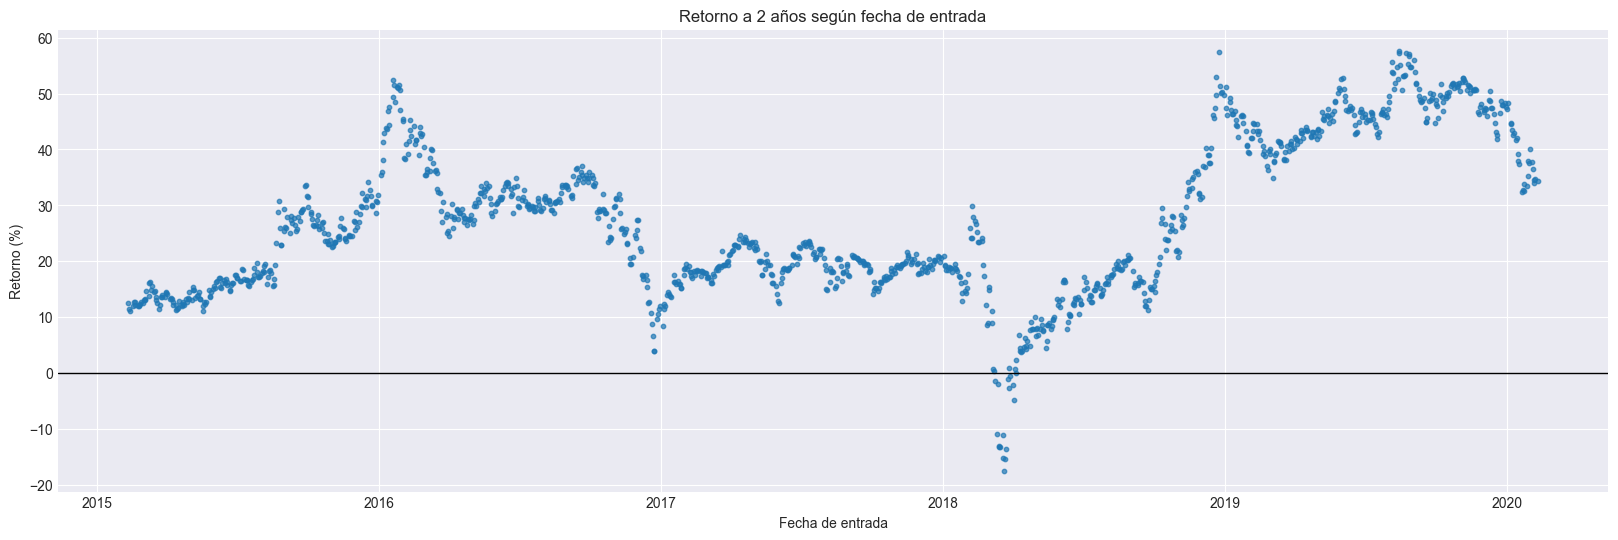

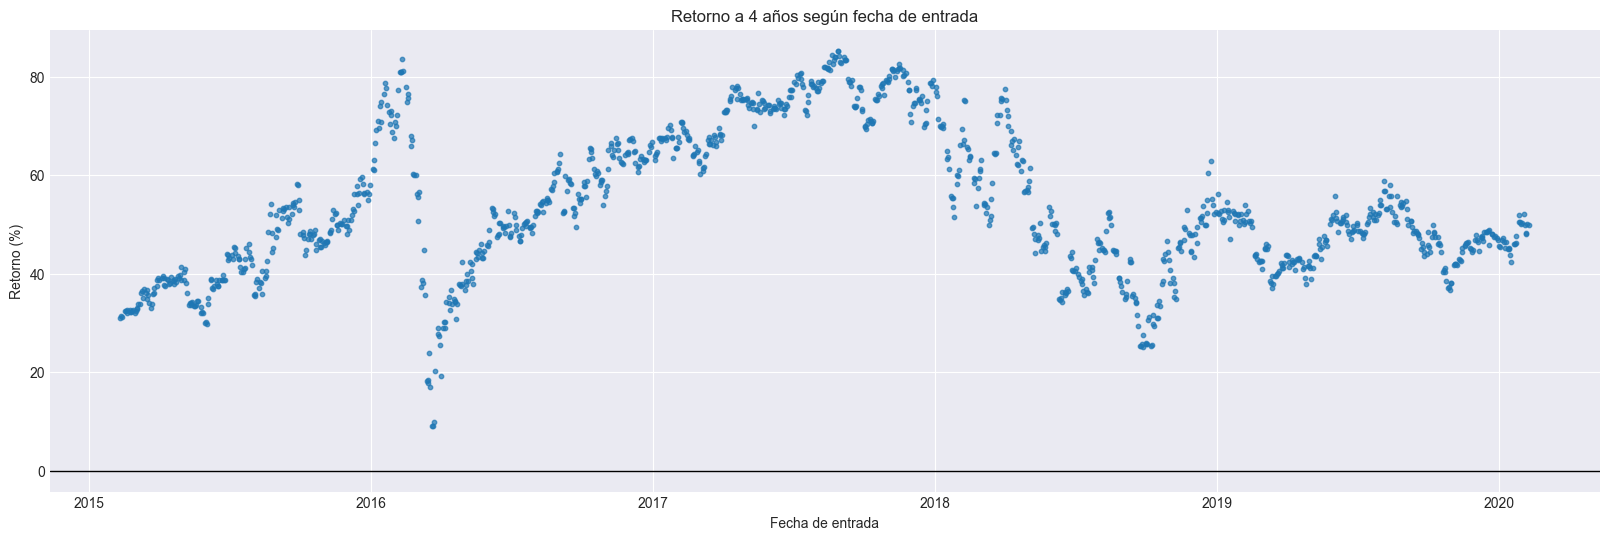

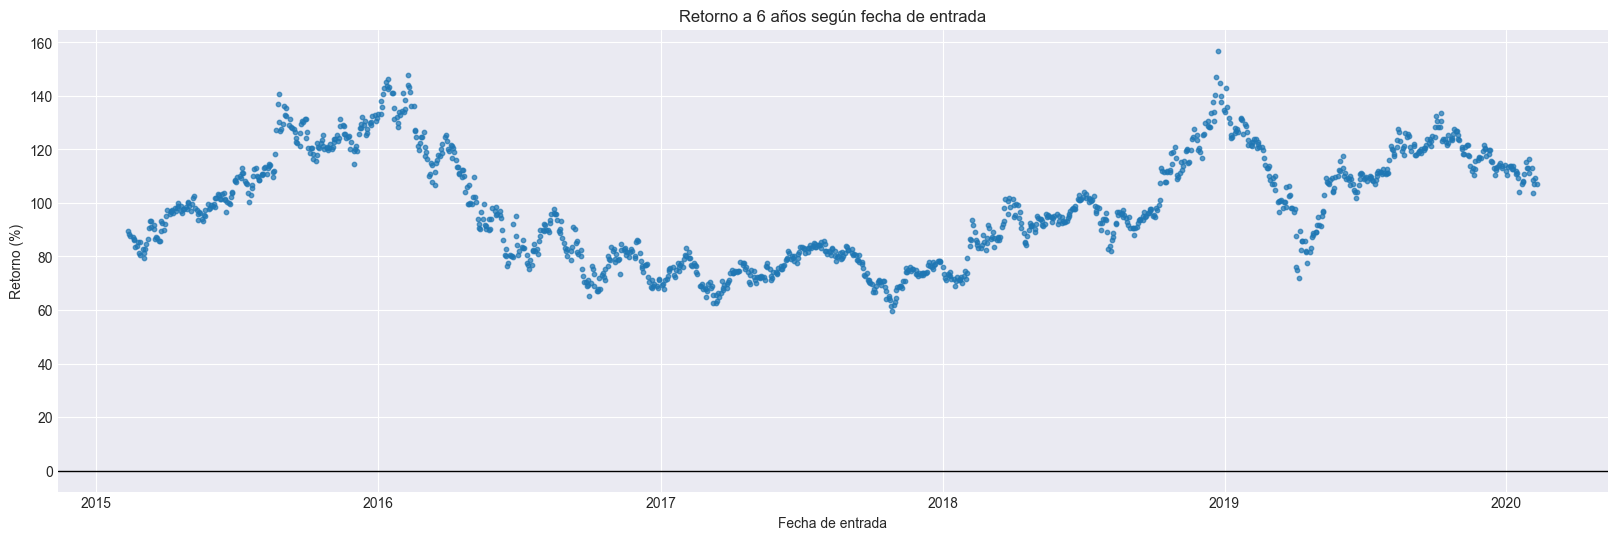

Horizonte 2 años:
  - Entradas consideradas: 1258
  - Retorno medio ≈ 27.17%
  - Mediana ≈ 24.50%
  - % de entradas positivas ≈ 98.73%
  - Mínimo ≈ -17.50%, Máximo ≈ 57.70%

Horizonte 4 años:
  - Entradas consideradas: 1258
  - Retorno medio ≈ 53.56%
  - Mediana ≈ 50.65%
  - % de entradas positivas ≈ 100.00%
  - Mínimo ≈ 9.06%, Máximo ≈ 85.28%

Horizonte 6 años:
  - Entradas consideradas: 1258
  - Retorno medio ≈ 98.55%
  - Mediana ≈ 96.45%
  - % de entradas positivas ≈ 100.00%
  - Mínimo ≈ 59.52%, Máximo ≈ 156.90%



In [ ]:
# Análisis: Entrando en cualquier fecha de los últimos 10 años,
# ¿siempre se obtiene buena rentabilidad a 2, 4 o 6 años?

from datetime import timedelta

plt.style.use('seaborn-v0_8-darkgrid')

# -----------------------
# Parámetros
# -----------------------
ticker = "^GSPC"
horizontes_years = [2, 4, 6]        # horizontes a evaluar: 2 años, 4 años y 6 años
years_back = 11                     # 11 años
min_date = None

# -----------------------
# Descargar datos
# -----------------------
end = pd.to_datetime("today").normalize()
start = end - pd.DateOffset(years = years_back)
df = yf.download(ticker, start = start.strftime("%Y-%m-%d"), end = end.strftime("%Y-%m-%d"), progress = False)

if df.empty:
    raise RuntimeError("No se descargaron datos.")

prices = df['Close'].dropna()
prices.name = "Close"

prices.index = pd.to_datetime(prices.index)

# -----------------------
# Generar fechas de entrada válidas
# -----------------------
all_dates = prices.index
results = []

for entry_date in all_dates:
    row = {'entry_date': entry_date}
    valid = True
    for years in horizontes_years:
        exit_date = entry_date + pd.DateOffset(years = years)
        # elegimos el precio de cierre más cercano al exit_date que exista en la serie (forward/backfill)
        # preferimos primer día >= exit_date
        future = prices[prices.index >= exit_date]
        if len(future) == 0:
            valid = False
            break
        price_entry = prices.loc[entry_date]
        price_exit = future.iloc[0]
        # rendimiento simple acumulado (porcentaje)
        ret = (price_exit / price_entry) - 1
        row[f'return_{years}y'] = ret
    if valid:
        results.append(row)

res_df = pd.DataFrame(results).set_index('entry_date').sort_index()
# Convertir a porcentaje
for years in horizontes_years:
    res_df[f'return_{years}y_pct'] = 100 * res_df[f'return_{years}y']

print(f"\nEntradas válidas consideradas: {len(res_df)}")

# -----------------------
# Estadísticas resumidas
# -----------------------
summary = {}
for years in horizontes_years:
    col = f'return_{years}y'
    arr = res_df[col].astype(float).values
    summary[years] = {
    'count': len(arr),
    'mean_pct': 100 * np.nanmean(arr),
    'median_pct': 100 * np.nanmedian(arr),
    'positive_frac': np.mean(arr > 0),
    'pct_pos_pct': 100 * np.mean(arr > 0),
    'min_pct': 100 * np.nanmin(arr),
    'max_pct': 100 * np.nanmax(arr),
    'std_pct': 100 * np.nanstd(arr),}


summary_df = pd.DataFrame(summary).T
summary_df = summary_df[['count','mean_pct','median_pct','pct_pos_pct','min_pct','max_pct','std_pct']]
summary_df.columns = ['N','mean (%)','median (%)','% positive','min (%)','max (%)','std (%)']
print("\nResumen estadístico (por horizontes):")
print(summary_df.round(3))

import os
out_dir = "gains_analysis_plots"
os.makedirs(out_dir, exist_ok = True)

for years in horizontes_years:
    col_pct = f'return_{years}y_pct'
    # Scatter: fecha de entrada vs retorno
    plt.figure(figsize = (20,6))
    plt.scatter(res_df.index, res_df[col_pct], s = 10, alpha = 0.7)
    plt.axhline(0, color='black', lw = 1)
    plt.title(f"Retorno a {years} años según fecha de entrada")
    plt.ylabel("Retorno (%)")
    plt.xlabel("Fecha de entrada")
    fname = f"{out_dir}/scatter_returns_{years}y.png"
    plt.savefig(fname, bbox_inches = 'tight', dpi = 150)
    plt.show()

# Convertir las columnas a float y eliminar valores no numéricos
ret2 = pd.to_numeric(res_df['return_2y_pct'], errors = 'coerce').dropna().to_numpy()
ret4 = pd.to_numeric(res_df['return_4y_pct'], errors = 'coerce').dropna().to_numpy()
ret6 = pd.to_numeric(res_df['return_6y_pct'], errors = 'coerce').dropna().to_numpy()

# -----------------------
# Resumen interpretativo automático
# -----------------------
for years in horizontes_years:
    r = summary[years]
    print(f"Horizonte {years} años:")
    print(f"  - Entradas consideradas: {r['count']}")
    print(f"  - Retorno medio ≈ {r['mean_pct']:.2f}%")
    print(f"  - Mediana ≈ {r['median_pct']:.2f}%")
    print(f"  - % de entradas positivas ≈ {100*r['positive_frac']:.2f}%")
    print(f"  - Mínimo ≈ {r['min_pct']:.2f}%, Máximo ≈ {r['max_pct']:.2f}%")
    print()

---

## Análisis de los Retornos del S&P 500 según el Horizonte Temporal

A continuación se presentan los retornos acumulados del índice **S&P 500** para distintos horizontes temporales, medidos desde cada fecha de entrada (inversión) dentro del período analizado:

- **Gráfico 1:** Retorno a 2 años  
- **Gráfico 2:** Retorno a 4 años  
- **Gráfico 3:** Retorno a 6 años  

Cada punto del gráfico representa el rendimiento total obtenido si se hubiera invertido en la fecha indicada ( eje x ) y mantenido la posición durante el plazo detallado.

---

## Estadísticas descriptivas de los retornos

| Horizonte | Entradas | Retorno Medio | Mediana | % Entradas Positivas | Mínimo | Máximo |
|------------|-----------|----------------|----------|------------------------|----------|----------|
| 2 años | 1258 | 25.03% | 21.94% | 98.73% | -17.50% | 57.70% |
| 4 años | 1258 | 52.61% | 50.62% | 100.00% | 9.06% | 85.28% |
| 6 años | 1258 | 96.46% | 93.49% | 100.00% | 59.52% | 156.90% |

<br>

---

## Interpretación de los resultados

- En el **horizonte de 2 años**, los retornos son más dispersos y pueden incluir períodos negativos, aunque el 98.7% de las entradas fueron positivas. Esto refleja que el riesgo de pérdidas existe en el corto plazo, pero es limitado.  
- En **4 años**, todos los retornos fueron positivos, y el promedio se duplica respecto al plazo de 2 años. El mercado muestra una clara tendencia a la recuperación y crecimiento sostenido.  
- En el **horizonte de 6 años**, los rendimientos se vuelven consistentemente altos, con un retorno medio cercano al 100% y sin registros negativos.  

<br>

> Se puede notar que de un horizonte temporal a otro, casi se duplica el rendimiento promedio.
---

## Conclusión

> El análisis cuantitativo confirma que el **riesgo de pérdida en el S&P 500 disminuye drásticamente con el horizonte temporal**.  
Mientras que las inversiones de corto plazo pueden verse afectadas por la volatilidad, los períodos de 4 a 6 años ofrecen **rendimientos estables y robustos**.  

<br>